### Platt Burges

&nbsp;
    
This model draws inspiration from Stanford CS229 Autumn 2016 Problem Set 4 Problem 2. Platt-Burges Model is used in NIPS for paper review calibration. Unfortunately, not much information of this model is disclosed to the general public. You have to settle with the limited description either on Neil Lawrence's personal blog or in Hong Ge's paper. Please note that these two authors solve the latent variable problem via regularized least squares. This script solves the latent variable problem via Expectation Minimization algorithm, exactly the same procedure as CS229 Problem Set 4.

Assuming $P$ papers are submitted to the conference and $R$ reviewers in the committee mark the score of these papers, each paper will be given $R$ different scores by all the reviewers. Therefore, the score of a paper given by a reviewer, denoted as $x$, can be decomposed into the linear combination of three components – the underlying intrinsic value $y$, the reviewer bias $z$ and some random disturbance $\epsilon$. $x$, $y$ and $z$ independently follow different Gaussian distributions.

$$ y^{(pr)} \sim \mathcal{N} (\mu_p,\sigma_p^2)$$

$$ z^{(pr)} \sim \mathcal{N} (\nu_r,\tau_r^2)$$

$$ x^{(pr)}|y^{(pr)},z^{(pr)} \sim \mathcal{N} (y^{(pr)}+z^{(pr)},\sigma^2)$$

E-Step

![alt text](./preview/e-step.JPG)

M-Step

![alt text](./preview/m-step.JPG)

&nbsp;

For RLS, plz check the below

https://github.com/je-suis-tm/machine-learning/blob/master/Wisdom%20of%20Crowds%20project/regularized%20least%20squares.ipynb

Reference to the original paper

https://github.com/je-suis-tm/machine-learning/blob/master/Wisdom%20of%20Crowds%20project/Regularized%20Least%20Squares%20to%20Remove%20Reviewer%20Bias.pdf

Reference to Hong Ge's paper

http://mlg.eng.cam.ac.uk/hong/unpublished/nips-review-model.pdf

Neil Lawrence's personal blog

https://inverseprobability.com/2014/08/02/reviewer-calibration-for-nips

Neil Lawrence's jupyter notebook

https://github.com/lawrennd/conference

Others' jupyter notebook

https://github.com/leonidk/reviewers

For discrete case, plz check Dawid-Skene Model

https://github.com/je-suis-tm/machine-learning/blob/master/Wisdom%20of%20Crowds%20project/dawid%20skene.ipynb

In [1]:
import matplotlib.pyplot as plt
import os
os.chdir('K:/ecole/github/televerser/wisdom of crowds')
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#raise error when zero is encountered in logarithm
np.seterr(divide='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Functions

In [3]:
#equations 1,2 in the problem set
def e_step(miu_p,sigma_p,nu_r,tau_r,X,sigma,):
    
    miu_pr_y=miu_p+np.multiply(
        np.divide(sigma_p,
                  (sigma+sigma_p+tau_r)),(X-miu_p-nu_r))
    miu_pr_z=nu_r+np.multiply(np.divide(
        tau_r,(sigma+sigma_p+tau_r)),(X-miu_p-nu_r))
    sigma_pr_yy=np.divide(
        np.multiply((tau_r+sigma),sigma_p),
        (sigma+sigma_p+tau_r))
    sigma_pr_zz=np.divide(
        np.multiply((sigma_p+sigma),tau_r),
        (sigma+sigma_p+tau_r))
    
    return miu_pr_y,miu_pr_z,sigma_pr_yy,sigma_pr_zz

In [4]:
#equations 3,4,5,6 in the problem set
def m_step(miu_pr_y,miu_pr_z,
           sigma_pr_yy,sigma_pr_zz):
    
    miu_p=np.repeat(
        miu_pr_y.mean(axis=0),miu_pr_y.shape[0],axis=0)
    nu_r=np.repeat(miu_pr_z.mean(axis=1),
                   miu_pr_z.shape[1],axis=1)
    sigma_p_temp=(sigma_pr_yy+np.square(miu_pr_y)- \
                  2*np.multiply(miu_pr_y,miu_p)+ \
                  np.square(miu_p)).mean(axis=0)
    sigma_p=np.repeat(sigma_p_temp.mean(axis=0),
                      miu_p.shape[0],axis=0)
    tau_r_temp=(sigma_pr_zz+np.square(miu_pr_z)- \
                2*np.multiply(miu_pr_z,nu_r)+ \
                np.square(nu_r)).mean(axis=1)
    tau_r=np.repeat(tau_r_temp.mean(axis=1),
                    miu_p.shape[1],axis=1)
    
    return miu_p,sigma_p,nu_r,tau_r

In [5]:
#compute lower bound to determine the convergence
def get_lower_bound(miu_pr_y,miu_pr_z,
                    sigma_pr_yy,sigma_pr_zz,
                    miu_p,sigma_p,nu_r,tau_r):

    var_y=sigma_pr_yy+np.square(miu_pr_y)- \
    2*np.multiply(miu_pr_y,miu_p)+np.square(miu_p)
    var_z=sigma_pr_zz+np.square(miu_pr_z)- \
    2*np.multiply(miu_pr_z,nu_r)+np.square(nu_r)

    logpdf=np.log(
        np.divide(
            1,np.multiply(
                sigma_p,tau_r)))-np.divide(
        var_y,sigma_p)/2-np.divide(var_z,tau_r)/2
    lower_bound=logpdf.sum()

    return lower_bound

In [6]:
#platt burges model solved in em algorithm
def platt_burges(X,tolerance=0.001,num_of_itr=200,
                 diagnosis=True):    
    
    #initialize intrinsic value
    miu_p=np.repeat(X.mean(axis=0),X.shape[0],axis=0)
    sigma_p=np.repeat(X.var(axis=0),X.shape[0],axis=0)

    #initialize banks bias level
    nu_r=np.repeat(X.mean(axis=1),X.shape[1],axis=1)
    tau_r=np.repeat(X.var(axis=1),X.shape[1],axis=1)

    #observed data
    sigma=np.empty(X.shape)
    sigma.fill(X.var())
    
    #initialize others
    lower_bound_old=None
    lower_bound=None
    counter=0

    while counter<num_of_itr:
                
        #e step
        miu_pr_y,miu_pr_z,sigma_pr_yy,sigma_pr_zz=e_step(
            miu_p,sigma_p,nu_r,tau_r,X,sigma,)
            
        #m step
        miu_p,sigma_p,nu_r,tau_r=m_step(
            miu_pr_y,miu_pr_z,sigma_pr_yy,sigma_pr_zz)
            
        counter+=1
        
        #use lower bound to determine if converged
        lower_bound_old=lower_bound
        lower_bound=get_lower_bound(miu_pr_y,miu_pr_z,
                                    sigma_pr_yy,
                                    sigma_pr_zz,
                                    miu_p,sigma_p,
                                    nu_r,tau_r)
            
        if lower_bound_old and \
        np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
                return miu_p[0],sigma_p[0],nu_r[:,0],tau_r[:,0]
            
    print('Not converged. Consider increase number of iterations or tolerance')
    return miu_p[0],sigma_p[0],nu_r[:,0],tau_r[:,0]


In [7]:
#create ridgeline plot
#the input data should be 2 dimensional
#one column for variable name
#the other for value
def create_ridgeline(data,values,variables,
                     title,xlabel,cmap):

    #crucial!
    #avoid bottom axis overlap
    sns.set_theme(style="white",
                  rc={"axes.facecolor":(0, 0, 0, 0)})
    
    #initialize the size
    g=sns.FacetGrid(data,row=variables,hue=variables,
                    aspect=10,height=.9,palette=cmap)

    #draw density
    g.map(sns.kdeplot,values,
          bw_adjust=.5,clip_on=False,
          fill=True,alpha=1,linewidth=1.5)

    #draw density boundary
    g.map(sns.kdeplot,values,clip_on=False,
          color="w",lw=2,bw_adjust=.5)

    #draw x axis
    g.map(plt.axhline,y=0,lw=2,clip_on=False)

    #define and use a simple function
    #to label the plot in axes coordinates
    def label(x,color,label):
        ax=plt.gca()
        ax.text(-.2,.2,label.replace(' ','\n'),
                fontweight="bold",color=color,
                ha="left",va="center",
                transform=ax.transAxes)

    #draw labels
    g.map(label,values)

    #set the subplots to overlap
    #think of it as tight layout
    g.fig.subplots_adjust(hspace=-.25)

    #remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.set_xlabels(xlabel)
    g.despine(bottom=True,left=True)
    g.fig.suptitle(title,fontweight="bold")
    plt.show()

### ETL

In [8]:
#read data
y0matrix2019=pd.read_csv('y0matrix2019.csv')

y1matrix2020=pd.read_csv('y1matrix2020.csv')

monthly=pd.read_csv('monthly.csv')

annual=pd.read_csv('annual.csv')

In [9]:
#set index
y0matrix2019.set_index('Source Name',inplace=True)

y1matrix2020.set_index('Source Name',inplace=True)

monthly.set_index('Date',inplace=True)
monthly.index=pd.to_datetime(monthly.index)
monthly.columns=y0matrix2019.columns

annual=annual.pivot(index='Date',
                    columns='Name',values='Value')
annual.index=pd.to_datetime(annual.index)
annual.columns=y0matrix2019.columns

In [10]:
#normalize forecast by pct return
y0_mat_nor=np.mat(
    np.divide(y0matrix2019,
              monthly['2019-08-31':'2019-08-31'])-1)
y1_mat_nor=np.mat(
    np.divide(y1matrix2020,
              monthly['2019-08-31':'2019-08-31'])-1)

In [11]:
#compute unit volatility
unit_volatility=monthly.std()/monthly.mean()

### Run Model and Forecast

In [12]:
y0_params=platt_burges(y0_mat_nor)
miu_p,sigma_p,nu_r,tau_r=y0_params

112 iterations to reach convergence



In [13]:
#revert to price forecast
y0_forecast=(miu_p+1)*monthly['2019-08-31':'2019-08-31']

#compute model error
pb_erreur_y0=abs(np.divide(y0_forecast,
                           annual['2019':'2019'])-1)

#compute simple average error
avg_erreur_y0=abs(np.divide(
    y0matrix2019.mean(axis=0).tolist(),
    annual['2019':'2019'])-1)

#compute spot price error
spot_erreur_y0=abs(np.divide(
    monthly['2019-08':'2019-08'],
    annual['2019':'2019'])-1)

In [14]:
#create dict
erreur_by_model_y0=list(
    pb_erreur_y0.to_dict(orient='index').values())[0]
erreur_by_cons_y0=list(
    avg_erreur_y0.to_dict(orient='index').values())[0]
erreur_by_spot_y0=list(
    spot_erreur_y0.to_dict(orient='index').values())[0]

#sort by spot error
erreur_by_spot_y0=dict(
    sorted(erreur_by_spot_y0.items(),key=lambda x:x[1]))

In [15]:
y1_params=platt_burges(y1_mat_nor)
miu_p,sigma_p,nu_r,tau_r=y1_params

121 iterations to reach convergence



In [16]:
#revert to price forecast
y1_forecast=(miu_p+1)*monthly['2019-08-31':'2019-08-31']

#compute model error
pb_erreur_y1=abs(np.divide(y1_forecast,
                           annual['2020':'2020'])-1)

#compute simple average error
avg_erreur_y1=abs(np.divide(
    y1matrix2020.mean(axis=0).tolist(),
    annual['2020':'2020'])-1)

#compute spot price error
spot_erreur_y1=abs(
    np.divide(monthly['2019-08':'2019-08'],
              annual['2020':'2020'])-1)

In [17]:
#create dict
erreur_by_model_y1=list(
    pb_erreur_y1.to_dict(orient='index').values())[0]
erreur_by_cons_y1=list(
    avg_erreur_y1.to_dict(orient='index').values())[0]
erreur_by_spot_y1=list(
    spot_erreur_y1.to_dict(orient='index').values())[0]

#sort by spot error
erreur_by_spot_y1=dict(
    sorted(erreur_by_spot_y1.items(),key=lambda x:x[1]))

### Bar Chart Viz

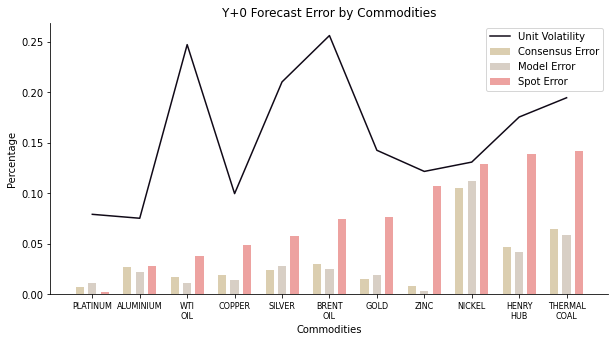

In [18]:
#viz
section_width=7
bar_width=4
intra_width=2
ticks=[]

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for ind,val in enumerate(erreur_by_spot_y0):
    x1=(ind+1)*section_width+(3*ind)*bar_width+ \
    (2*ind)*intra_width
    x2=x1+bar_width+intra_width
    x3=x2+bar_width+intra_width
    bar1=plt.bar(x1,erreur_by_cons_y0[val],
            color='#DBCEB0',width=bar_width)
    bar2=plt.bar(x2,erreur_by_model_y0[val],
            color='#d8cfc5',width=bar_width)
    bar3=plt.bar(x3,erreur_by_spot_y0[val],
            color='#eda2a0',width=bar_width)
    ticks.append(x2)
line,=plt.plot(ticks,
               unit_volatility[erreur_by_spot_y0.keys()],
               c='#100917')
plt.xticks(ticks,
           [i.replace(
            ' ','\n') for i in erreur_by_spot_y0.keys()],
           fontsize=8)
plt.legend((line,bar1,bar2,bar3),
           ('Unit Volatility',
            'Consensus Error',
            'Model Error',
            'Spot Error'),loc=0)
plt.xlabel('Commodities')
plt.ylabel('Percentage')
plt.title('Y+0 Forecast Error by Commodities')
plt.show()

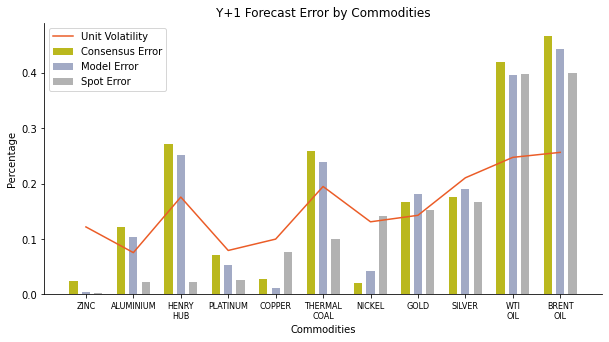

In [19]:
#viz
section_width=7
bar_width=4
intra_width=2
ticks=[]

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for ind,val in enumerate(erreur_by_spot_y1):
    x1=(ind+1)*section_width+(3*ind)*bar_width+ \
    (2*ind)*intra_width
    x2=x1+bar_width+intra_width
    x3=x2+bar_width+intra_width
    bar1=plt.bar(x1,erreur_by_cons_y1[val],
            color='#bab81e',width=bar_width)
    bar2=plt.bar(x2,erreur_by_model_y1[val],
            color='#a2aac5',width=bar_width)
    bar3=plt.bar(x3,erreur_by_spot_y1[val],
            color='#B2B2B2',width=bar_width)
    ticks.append(x2)
line,=plt.plot(ticks,
               unit_volatility[erreur_by_spot_y1.keys()],
               c='#eb5c27')

plt.xticks(ticks,
        [i.replace(
            ' ','\n') for i in erreur_by_spot_y1.keys()],
           fontsize=8)
plt.legend((line,bar1,bar2,bar3),
           ('Unit Volatility',
            'Consensus Error',
            'Model Error',
            'Spot Error'),loc=0)
plt.xlabel('Commodities')
plt.ylabel('Percentage')
plt.title('Y+1 Forecast Error by Commodities')
plt.show()

### Distribution Chart Viz

In [20]:
#unpack
_,_,nu_r,tau_r=y0_params

#sort by mean of banks bias
y0_gaussian={}
for ind,val in enumerate(y0matrix2019.index):
    y0_gaussian[val]=(nu_r[ind].item(),
                      tau_r[ind].item()**0.5,
                     y0_mat_nor[ind].ravel().tolist()[0])
y0_gaussian=dict(sorted(y0_gaussian.items(),
                        key=lambda x:x[1][0]))

#create dataframe
ridgeline=pd.DataFrame()
ridgeline['value']=[
    j for i in y0_gaussian for j in y0_gaussian[i][2]]
ridgeline['banks']=[
    j+f' µ={round(y0_gaussian[i][0],6)} σ={round(y0_gaussian[i][1],6)}' for i in y0_gaussian for j in [i]*len(y0_gaussian[i][2])]

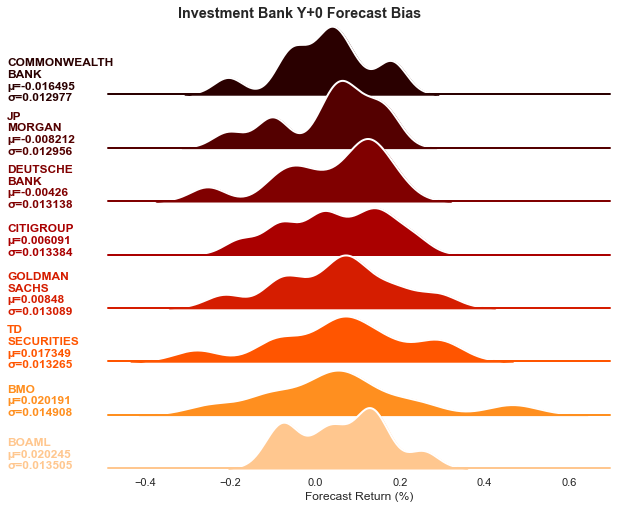

In [21]:
cmap="gist_heat"
values='value'
variables='banks'
title='Investment Bank Y+0 Forecast Bias'
xlabel="Forecast Return (%)"

create_ridgeline(ridgeline,values,variables,
                     title,xlabel,cmap)

In [22]:
#unpack
_,_,nu_r,tau_r=y1_params

#sort by mean of banks bias
y1_gaussian={}
for ind,val in enumerate(y1matrix2020.index):
    y1_gaussian[val]=(nu_r[ind].item(),
                      tau_r[ind].item()**0.5,
                     y1_mat_nor[ind].ravel().tolist()[0])
y1_gaussian=dict(sorted(y1_gaussian.items(),
                        key=lambda x:x[1][0]))

#create dataframe
ridgeline=pd.DataFrame()
ridgeline['value']=[
    j for i in y1_gaussian for j in y1_gaussian[i][2]]
ridgeline['banks']=[
    j+f' µ={round(y1_gaussian[i][0],6)} σ={round(y1_gaussian[i][1],6)}' for i in y1_gaussian for j in [i]*len(y1_gaussian[i][2])]

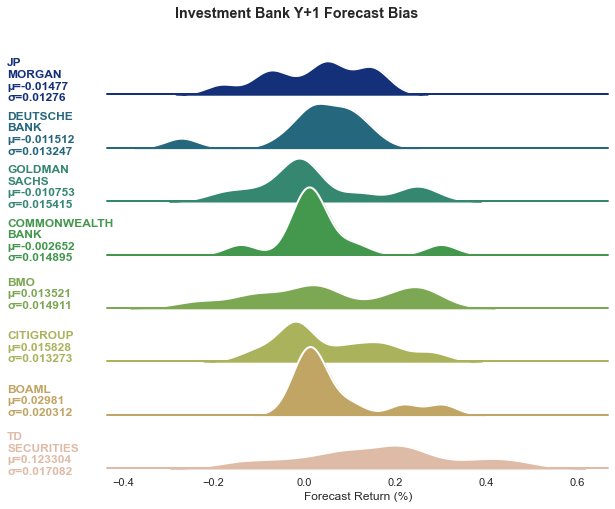

In [23]:
cmap="gist_earth"
values='value'
variables='banks'
title='Investment Bank Y+1 Forecast Bias'
xlabel="Forecast Return (%)"

create_ridgeline(ridgeline,values,variables,
                     title,xlabel,cmap)